In [17]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from collections import deque
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

In [18]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [19]:
with open('phase2_gnndnn_scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
feature_columns = [
    "bwd packets/s",
    "destination port",
    "init_win_bytes_forward",
    "flow packets/s",
    "bwd packet length min",
    "down/up ratio",
    "psh flag count",
    "act_data_pkt_fwd",
    "total fwd packets",
    "subflow fwd bytes",
]
print(scaler.n_features_in_)

10


In [21]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [22]:
model = GraphNet(
    in_channels=len(feature_columns),  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2           # final classes (0=Benign, 1=Attack)
)
model.load_state_dict(torch.load("GNN_DNN_top10.pth", map_location=torch.device('cpu')))
model.eval()

GraphNet(
  (gcn1): GCNConv(10, 128)
  (gcn2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [26]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3

print("Starting to consume messages...")

for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    row_df[feature_columns] = dynamic_scaler.transform(row_df[feature_columns])

    X_new = row_df[feature_columns].values  # shape: [1, n_features]
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    replay_buffer.append((X_new[0], y_new))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:

        current_window = list(window_data)
        # Sample an equal number of past samples (if available)
        sample_size = min(len(current_window), len(replay_buffer))
        if sample_size > 0:
            # Randomly choose indices from the replay buffer
            replay_indices = np.random.choice(len(replay_buffer), sample_size, replace=False)
            replay_samples = [replay_buffer[i] for i in replay_indices]
        else:
            replay_samples = []
        combined = current_window + replay_samples

        # Extract ground truth and predictions from the window
        X_window = np.array([entry[0] for entry in combined])
        y_window = np.array([entry[1] for entry in combined])

        X_window_df = pd.DataFrame(X_window, columns=feature_columns)
        # For evaluation, generate inputs for each model using its respective scaler.
        X_window_dynamic = dynamic_scaler.transform(X_window_df)
        X_window_static = static_scaler.transform(X_window_df)
        
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        X_window_dynamic_tensor = torch.tensor(X_window_dynamic, dtype=torch.float32)
        X_window_static_tensor = torch.tensor(X_window_static, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_dynamic_tensor, edge_index)
            static_logits = static_model(X_window_static_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()


        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel() if len(np.unique(y_window)) == 2 else (None, None, None, None)
        if len(np.unique(y_window)) == 2:
            tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel()
            fpr_value = fp / (fp + tn) if (fp + tn) > 0 else None
        else:
            fpr_value = None

        print(f"\nWindow complete: Dynamic F1 = {current_dynamic_f1:.3f}, Static F1 = {current_static_f1:.3f}")
        print(f"Dynamic Precision = {current_precision:.3f}, Dynamic Recall = {current_recall:.3f}, Dynamic FPR = {fpr_value}")
        
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
        if current_dynamic_f1 < 0.75:
            print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")

            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)

            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            X_window_dynamic_scaled = dynamic_scaler.transform(X_window_df)

            knn_graph = kneighbors_graph(X_window_dynamic_scaled, n_neighbors=k, include_self=False)
            row_idx, col_idx = knn_graph.nonzero()
            edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

            X_window_dynamic_tensor = torch.tensor(X_window_dynamic_scaled, dtype=torch.float32)

            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 80  # adjust as needed
            
            for epoch in range(1, num_epochs + 1):
                optimizer.zero_grad()
                outputs = dynamic_model(X_window_dynamic_tensor, edge_index)  # Forward pass
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0 or epoch == num_epochs:
                    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")
            dynamic_model.eval()

        # Clear the window for the next batch
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming from Kafka or timed out.")

Starting to consume messages...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Consumed 0 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 0.000, Static F1 = 0.000
Dynamic Precision = 0.000, Dynamic Recall = 0.000, Dynamic FPR = None
Dynamic model F1 (0.000) is below threshold. Retraining dynamic model on this window...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 20/80 - Loss: 0.0001
Epoch 40/80 - Loss: 0.0000
Epoch 60/80 - Loss: 0.0000
Epoch 80/80 - Loss: 0.0000
Consumed 1000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 1900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.194
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 2000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 2900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.219
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 3000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 3900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.232
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 4000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 4900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.253
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 5000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 5900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.212
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 6000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 6900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.225
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 7000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 7900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj


Window complete: Dynamic F1 = 1.000, Static F1 = 0.252
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Consumed 8000 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Skipping row with invalid label: ['"bwd packets/s', 'destination port', 'init_win_bytes_forward', 'flow packets/s', 'bwd packet length min', 'down/up ratio', 'psh flag count', 'act_data_pkt_fwd', 'total fwd packets', 'subflow fwd bytes', 'label\\n"']


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 8900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.201
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 9900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.206
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 10900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.206
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 11900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.208
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 12900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.197
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 13900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.231
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14100 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14200 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14300 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14400 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14500 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14600 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14700 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14800 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 14900 messages


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\Final_Proj

Consumed 15000 messages

Window complete: Dynamic F1 = 1.000, Static F1 = 0.233
Dynamic Precision = 1.000, Dynamic Recall = 1.000, Dynamic FPR = None
Reached max window steps (15). Exiting...
Finished streaming from Kafka or timed out.


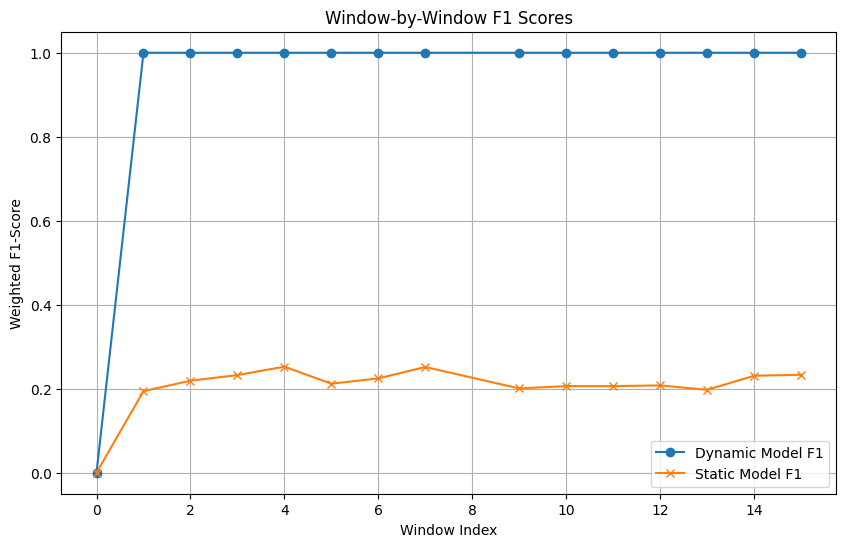

In [27]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()
